## TTCT Figural Image Registration

While MOTES Figural will likely not include a paper component, for piloting with TTCT data, we need to extract images of the test responses. First step is image registration, which essentially aligns two images. The intent is to scale and warp each test page to so that they can all be cropped identically.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
from IPython.display import display
from figural.alignment import *
from tqdm.auto import tqdm
poppler_path = '/opt/homebrew/bin/'
data_dir = Path('../../data/')
meta = pd.read_csv(data_dir/'booklet-meta.csv', index_col=0)
path_info = pd.DataFrame([(name_from_path(path), path) for path in Path(data_dir / 'ttct_figural').glob('**/*pdf')], columns=['id', 'path'])
meta = meta.merge(path_info)
meta.sample(1)

,id,booklet,titlepage,path
745,f520c-69221,BOOKLETB,3,../../data/ttct_figural/McCammon Am CA213 TTCT...


In [ ]:
# load booklet targets 
target_b = Booklet(data_dir / 'blank-bookletB_cleaned.pdf', first_page=2, poppler_path=poppler_path, booklet='b')
target_a = Booklet(data_dir / 'blank-bookletA_cleaned.pdf', first_page=2, poppler_path=poppler_path, booklet='a')
target_a.get_activity('2b', mod=-100, square=True, use_originals=True)

## Example: Aligning Double-page Scans

In [11]:
sample = meta.query('booklet == "BOOKLETB"').sample(1).iloc[0]
sample[['path', 'titlepage', 'booklet']]

path         ../../data/ttct_figural/Mills Sunday PM TTCT E...
titlepage                                                    3
booklet                                               BOOKLETB
Name: 641, dtype: object

In [13]:
# load source booklet that will be aligned
booklet = Booklet(sample.path, sample.titlepage+1, target_booklet=target_b, booklet=sample.booklet.lower()[-1], poppler_path=poppler_path)

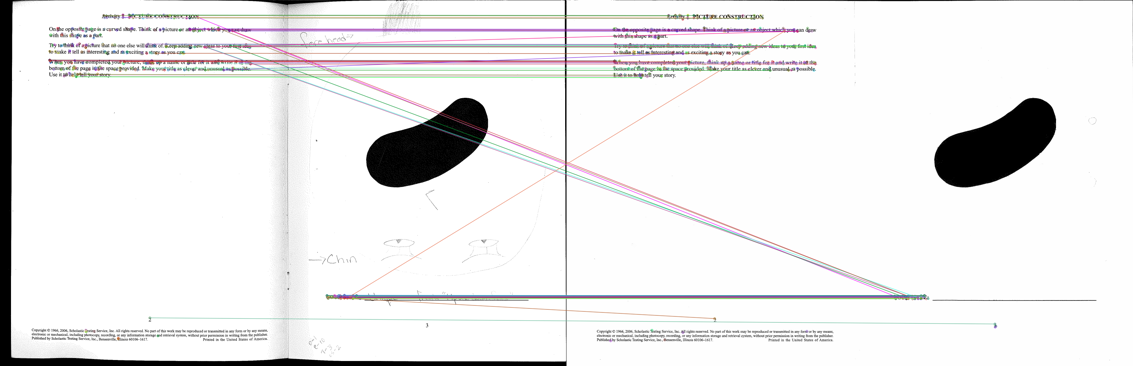

In [14]:
# Align with target booklet. include_matches isn't needed in production
reg, matches = booklet.align(include_matches=True, format="auto", good_match_percent=0.15)

w, h = matches[0].size
matches[1].crop((0,0,w, h-100)).save(data_dir / 'example_registration.png')
matches[0].resize((w//3, h//3))

### Issue: Activity three doesn't align properly

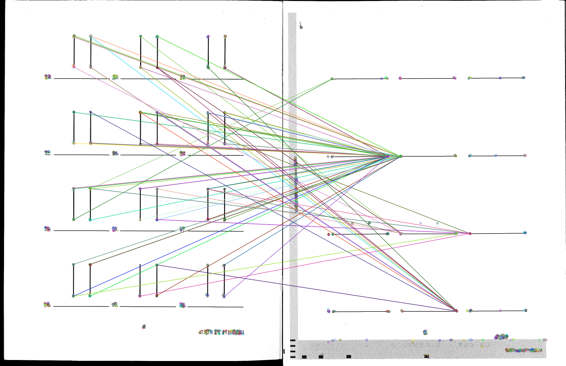

In [9]:
w, h = matches[3].size
matches[3].resize((w//3, h//3))

`booklet.composite()` can patch together the registered source with the target. Note that this will only *redo* alignment with `force=True`. You can pass kwargs to `align`. This can be good to see the quality of alignment.

`booklet.align()` can be done on single format or double format pages, though it always saves the images as doubleformat. Some pages are aligned better split up, others together. `format='smart'` tries to do this selectively.

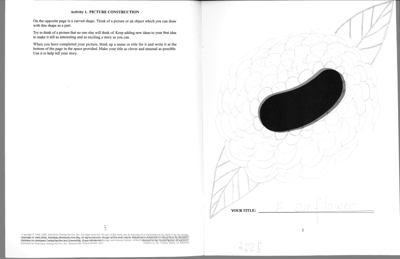

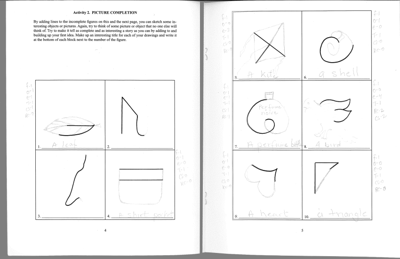

In [250]:
for page in booklet.composite(force=True, format='smart', good_match_percent=0.15)[:2]:
    b = page.copy()
    b.thumbnail((400,400))
    display(b)

## Example: Single-page scans

Some scans are single sided. I try to handle this.

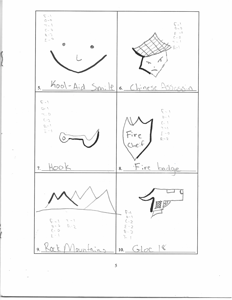

In [15]:
# example of a booklet that doesn't have doublesided pages
sample = meta[meta.id.str.endswith('68724')].iloc[0]
booklet = Booklet(sample.path, sample.titlepage+1, target_booklet=target_a, booklet=sample.booklet.lower()[-1], poppler_path=poppler_path)
b = booklet[3].copy()
b.thumbnail((300,300))
b

Running alignment first


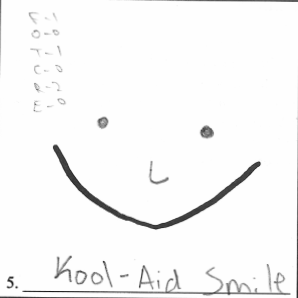

In [16]:
booklet.get_activity('2e', format='smart', square=True)

activity1


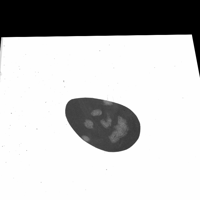

activity2a


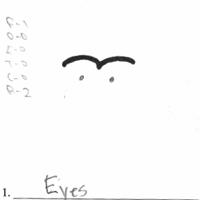

activity2b


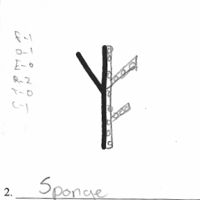

activity2c


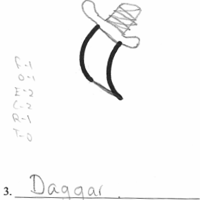

activity2d


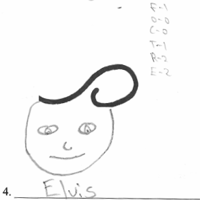

activity2e


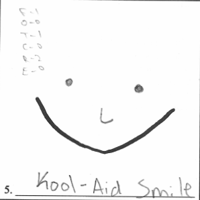

activity2f


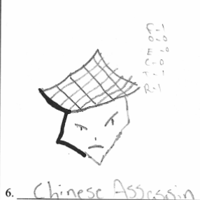

activity2g


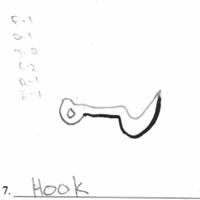

activity2h


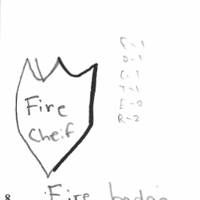

activity2i


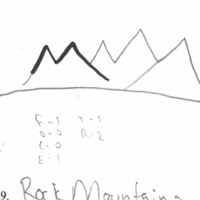

activity2j


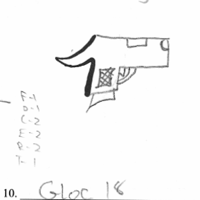

In [17]:
for name, img in booklet.get_all_activities(format='smart', square=True).items():
    print(name)
    b = img.copy()
    b.thumbnail((200,200))
    display(b)

## Extract activities 1 and 2

Also export a spreadsheet for easy coding

In [24]:
target_b

In [28]:
target_booklet = 'b'
target = target_a if target_booklet == 'a' else target_b
to_process = meta.query(f'booklet == "BOOKLET{target_booklet.upper()}"')

# export larger viewport and a coding spreadsheet
save_for_coding = False

if save_for_coding:
    outs = data_dir / f'outputs/for_coding_{target_booklet}'
    # create blank coding spreadsheet
    code_sheet = to_process.copy()
    cats = ['error', 'F', 'O', 'T', 'C', 'R', 'E', 'notes']
    code_sheet[cats] = None

    for activity in target.cropmap[f'booklet_{target_booklet}'].keys():
        (outs / activity).mkdir(parents=True, exist_ok=True)
        code_sheet[['id', 'path']+cats].sort_values('id').to_csv(outs / activity / f'coding-{target_booklet}-{activity}.csv')
else:
    outs = data_dir / f'outputs/booklet{target_booklet}'
    for activity in target.cropmap[f'booklet_{target_booklet}'].keys():
        (outs / activity).mkdir(parents=True, exist_ok=True)

outs.mkdir(parents=True, exist_ok=True)

In [29]:
## Extract images
errs = []
fix_activity_1 = True
for ind, item in tqdm(list(to_process.iterrows())):
    try:
        # load source booklet that will be aligned
        booklet = Booklet(item.path, item.titlepage+1,
                          target_booklet=target_b if target_booklet == 'b' else target_a,
                          booklet=item.booklet.lower()[-1],
        poppler_path=poppler_path)

        booklet.align(format='smart')
        # export everything
        for name, img in booklet.get_all_activities(square=True, mod=-100 if save_for_coding else 0).items():
            img.save(outs / name / f"{item.id.strip()}.jpg")

        if fix_activity_1: # export full activity 1 page for coding
            im = booklet.get_page(1)
            im = im.crop((im.width//2, 0, im.width, im.height))
            im.resize((im.width//2, im.height//2)).save(outs / 'activity1' / f"{item.id.strip()}.jpg")

    except KeyboardInterrupt:
        raise

    except:
        print(f"Issue with path {item.path}")
        errs.append(ind)

if len(errs):
    to_process.loc[errs].to_csv(outs / 'errors.csv')

if save_for_coding:
    !zip ../../data/outputs/for_coding_{target_booklet}.zip ../../data/outputs/for_coding_{target_booklet}/*
    !rm -rf ../../data/outputs/for_coding_{target_booklet}

  0%|          | 0/430 [00:00<?, ?it/s]

I did some manual sorting of files after the first time running this - where the booklets was incorrect (e.g. activity 1 had a jellybean but was read as booklet A). Those reclassifications were added to the hardcoded fixes in `booklet_id.ipynb`. Then reran this notebook from scratch.

I also manually classed reg errors.

In [ ]:
# hardcoded from manual review
regerrs = dict()
regerrs['activity1'] = ['9508e-68724', 'b5b5f-79047', '9508e-47261', '9508e-1438', 'dee97-71558 M', 'b5b5f-74951', 'b5b5f-78819', 'dee97-69433 M', '.DS_Store', 'dee97-64546', 'dee97-51927', 'dee97-74768', 'b5b5f-71542', 'b5b5f-77829', 'b5b5f-80287', 'dee97-76132', '9508e-71576', 'dee97-61601 M', '9508e-71601', 'dee97-69412 M', 'b5b5f-63869', 'dee97-71246', 'b5b5f-79207', 'b5b5f-76123', 'dee97-73321', 'b5b5f-78888', '9508e-67863', 'b5b5f-67808', 'dee97-7534', 'dee97-76285 M', 'b5b5f-74804', 'b5b5f-80188', 'b5b5f-79277', 'b5b5f-76145', 'b5b5f-76543', 'dee97-74015 M', '9508e-72771', 'b5b5f-74369']

In [575]:
to_process.loc[errs].sample(frac=1).path.tolist()

[]

### A video animation to quickly inspect for egregious errors

In [ ]:
vidpath = Path('../data/frames')
vidpath.mkdir(exist_ok=True)
l = 200
cols, rows = 4,3
for name in [x.stem for x in (outs / 'activity1').glob('*jpg')]:
    a = Image.new(size=(l*cols, l*rows), mode='RGB', color='white')
    for i, activity in enumerate(target_a.cropmap['booklet_a'].keys()):
        left, top = l*(i%cols), l*(i//cols)
        fpath = outs / activity / f"{name}.jpg"
        try:
            img  = Image.open(fpath).resize((l,l))
            a.paste(img, (left, top))
        except:
            raise
            print('skipping', fpath)
    a.save(vidpath/ f'{name}.jpg')
outpath = f"../data/vids/all.mp4"
!/opt/homebrew/bin/ffmpeg -y -r 15 -pattern_type glob -i '../data/frames/*.jpg'  -c:v libx264 -vf fps=25 -pix_fmt yuv420p $outpath
!open $outpath
!rm -rf ../data/vid